# Importing Datasets


In [1]:
import pandas as pd  # For data handling
import numpy as np  # For numerical operations
import networkx as nx  # For graph algorithms
import ast  # To safely parse edge list strings into Python lists
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For advanced plots
from sklearn.model_selection import GroupKFold, GridSearchCV  # Grouped cross-validation and hyperparameter tuning
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
# 1. Load datasets
train_df = pd.read_csv('train.csv')  # Load training data
test_df = pd.read_csv('test.csv')  # Load test data

# Initial Data Exploration

In [3]:

print(train_df.head(10))  # Show first few rows


   language  sentence   n                                           edgelist  \
0  Japanese         2  23  [(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...   
1  Japanese         5  18  [(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...   
2  Japanese         8  33  [(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...   
3  Japanese        11  30  [(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...   
4  Japanese        12  19  [(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...   
5  Japanese        14  29  [(23, 29), (18, 23), (28, 18), (28, 12), (28, ...   
6  Japanese        16  19  [(19, 7), (14, 19), (16, 8), (15, 16), (13, 15...   
7  Japanese        21  19  [(9, 10), (14, 9), (18, 14), (7, 8), (16, 7), ...   
8  Japanese        25  19  [(11, 6), (18, 11), (13, 5), (18, 13), (10, 8)...   
9  Japanese        26  23  [(8, 23), (17, 8), (7, 17), (6, 5), (19, 6), (...   

   root  
0    10  
1    10  
2     3  
3    30  
4    11  
5     6  
6    14  
7    18  
8     7  
9     3  


In [4]:
print(train_df.describe())  # Summary statistics


           sentence             n          root
count  10500.000000  10500.000000  10500.000000
mean     494.778000     18.807524      9.844476
std      290.256632      8.190593      7.207740
min        2.000000      3.000000      1.000000
25%      233.500000     13.000000      4.000000
50%      483.000000     18.000000      8.000000
75%      742.250000     23.000000     14.000000
max      995.000000     70.000000     68.000000


In [5]:
print(train_df['language'].value_counts())  # Check language distribution

language
Japanese      500
German        500
Arabic        500
Portuguese    500
Chinese       500
Czech         500
Turkish       500
Thai          500
Polish        500
Korean        500
Icelandic     500
Finnish       500
Spanish       500
Swedish       500
Indonesian    500
Italian       500
French        500
Hindi         500
English       500
Galician      500
Russian       500
Name: count, dtype: int64


In [6]:
train_df.isna().sum()  # Check for missing values

language    0
sentence    0
n           0
edgelist    0
root        0
dtype: int64

# Visualization: Sentence lengths

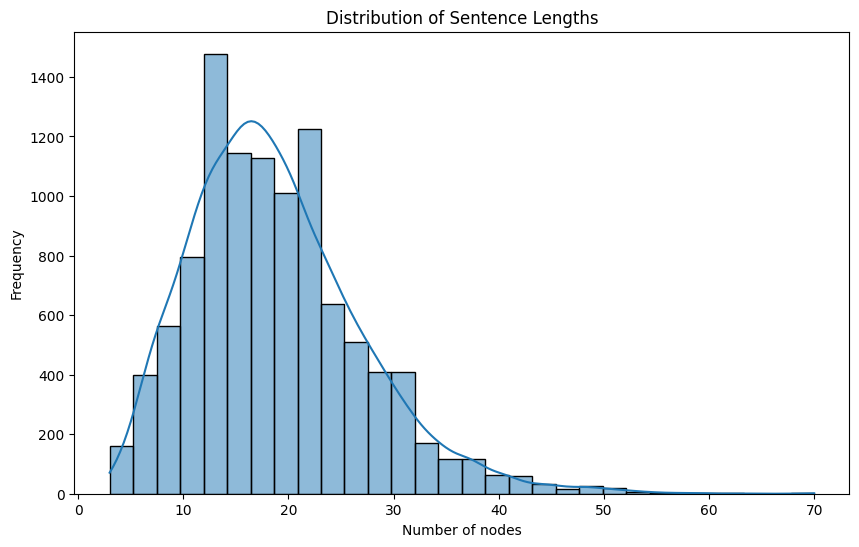

In [7]:

plt.figure(figsize=(10,6))
sns.histplot(train_df['n'], bins=30, kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of nodes')
plt.ylabel('Frequency')
plt.show()

# Data preprocessing

In [8]:
# 2. Function to extract centralities

def compute_centralities(edge_list):
    T = nx.from_edgelist(edge_list)
    n = T.number_of_nodes()
    
    # Centrality measures
    dc = nx.degree_centrality(T)
    hc = nx.harmonic_centrality(T)
    bc = nx.betweenness_centrality(T)
    pr = nx.pagerank(T)
    clc = nx.closeness_centrality(T)
    try:
        kc = nx.katz_centrality(T, alpha=0.1)
    except:
        kc = {v: 0 for v in T.nodes()}
    lc = nx.load_centrality(T)
    andc = nx.average_neighbor_degree(T)

    # Return per-node dictionary
    return {
        v: (
            dc[v], hc[v], bc[v], pr[v], kc[v], lc[v], andc[v], clc[v]
        )
        for v in T
    }




In [9]:
# 3. Build expanded training data with extended centrality and graph metrics
train_rows = []
for idx, row in train_df.iterrows():
    edges = ast.literal_eval(row['edgelist'])
    T = nx.from_edgelist(edges)
    centralities = compute_centralities(edges)
    root = row['root']
    for node, feats in centralities.items():
        train_rows.append({
            'language': row['language'],
            'sentence': row['sentence'],
            'node': node,
            'n_nodes': row['n'],
            'deg_cent': feats[0],
            'harm_cent': feats[1],
            'betw_cent': feats[2],
            'pagerank': feats[3],
            'katz_cent': feats[4],
            'load_cent': feats[5],
            'avg_neigh_deg': feats[6],
            'closeness_cent': feats[7],
            'target': 1 if node == root else 0
        })


In [10]:
expanded_train = pd.DataFrame(train_rows)
print(expanded_train.head(20))  # Show first few rows of expanded training data

    language  sentence  node  n_nodes  deg_cent  harm_cent  betw_cent  \
0   Japanese         2     6       23  0.090909   5.823846   0.090909   
1   Japanese         2     4       23  0.045455   4.561122   0.000000   
2   Japanese         2     2       23  0.136364   6.991703   0.255411   
3   Japanese         2    23       23  0.045455   5.157179   0.000000   
4   Japanese         2    20       23  0.090909   7.146825   0.311688   
5   Japanese         2    15       23  0.136364   8.038492   0.627706   
6   Japanese         2     3       23  0.090909   5.259535   0.090909   
7   Japanese         2     5       23  0.045455   4.196440   0.000000   
8   Japanese         2    14       23  0.090909   5.865512   0.173160   
9   Japanese         2     8       23  0.090909   6.382179   0.246753   
10  Japanese         2    12       23  0.090909   6.980159   0.311688   
11  Japanese         2     9       23  0.090909   7.317857   0.523810   
12  Japanese         2    18       23  0.090909   7

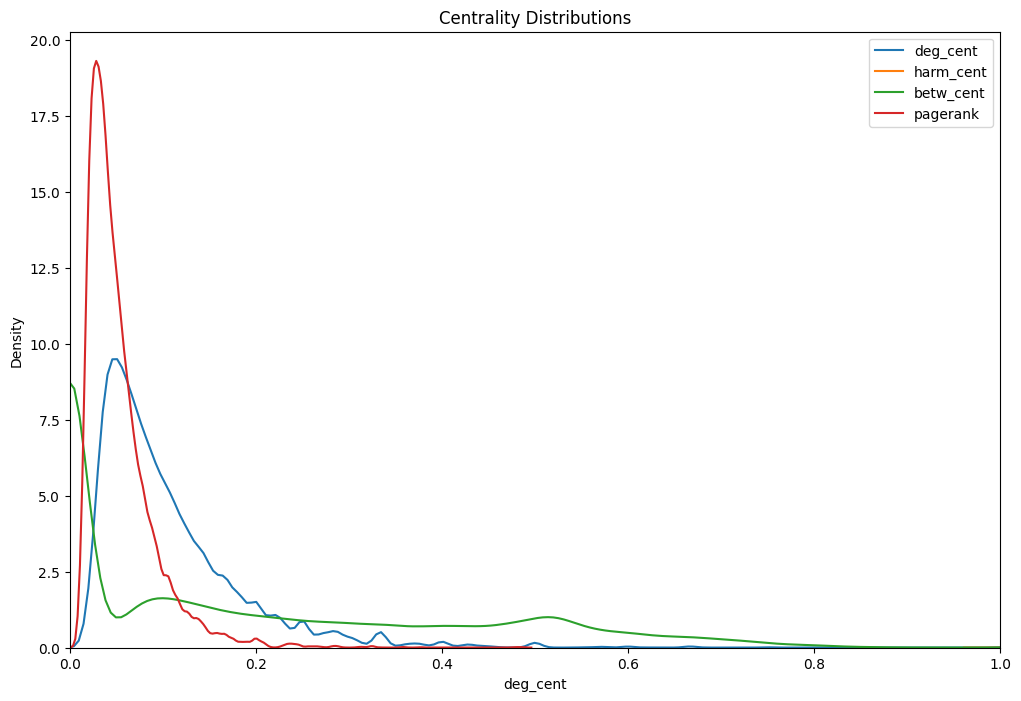

In [11]:
# 4. Analyze Centrality Distributions
plt.figure(figsize=(12,8))
for feature in ['deg_cent', 'harm_cent', 'betw_cent', 'pagerank']:
    sns.kdeplot(expanded_train[feature], label=feature)
plt.title('Centrality Distributions')
plt.legend()
plt.xlim(0, 1)  # Limit x-axis from 0 to 5
plt.show()


In [12]:
from sklearn.preprocessing import MinMaxScaler

# Updated feature list based on new centrality and graph metrics
features = [
    'deg_cent', 'harm_cent', 'betw_cent', 'pagerank', 'katz_cent', 'load_cent',
    'avg_neigh_deg', 'closeness_cent', 
]

# Normalize each feature per (language, sentence) group
expanded_train[features] = expanded_train.groupby(['language', 'sentence'])[features]\
    .transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).flatten())


In [13]:
expanded_train

language  sentence  node  n_nodes  deg_cent  harm_cent  betw_cent  \
0       Japanese         2     6       23      0.50   0.423577   0.144828   
1       Japanese         2     4       23      0.00   0.094919   0.000000   
2       Japanese         2     2       23      1.00   0.727544   0.406897   
3       Japanese         2    23       23      0.00   0.250059   0.000000   
4       Japanese         2    20       23      0.50   0.767919   0.496552   
...          ...       ...   ...      ...       ...        ...        ...   
197474   Russian       995    19       19      0.00   0.160469   0.000000   
197475   Russian       995     1       19      0.00   0.370170   0.000000   
197476   Russian       995    14       19      0.00   0.370170   0.000000   
197477   Russian       995     5       19      0.25   0.505982   0.178947   
197478   Russian       995    16       19      0.00   0.160469   0.000000   

        pagerank  katz_cent  load_cent  avg_neigh_deg  closeness_cent  target  
0       0.560736   0.489002   0.144828       0.333333        0.304348       0  
1       0.047986   0.004617   0.000000       0.333333        0.132075       0  
2       1.000000   0.945117   0.406897       0.111111        0.512605       0  
3       0.007641   0.050228   0.000000       1.000000        0.285714       0  
4       0.416681   0.588540   0.496552       1.000000        0.730769       0  
...          ...        ...        ...            ...             ...     ...  
197474  0.027369   0.007346   0.000000       0.142857        0.198660       0  
197475  0.003067   0.077315   0.000000       1.000000        0.412509       0  
197476  0.003067   0.077315   0.000000       1.000000        0.412509       0  
197477  0.278910   0.300308   0.178947       0.428571        0.448047       0  
197478  0.027369   0.007346   0.000000       0.142857        0.198660       0  

[197479 rows x 13 columns]

# Create a Train - Validation Set

In our dataset, each row represents a node within a graph, and each graph corresponds to a unique (language, sentence) pair. To ensure that the model evaluation is valid, we perform grouped splitting based on these identifiers.

If we randomly split individual rows into training and validation sets, nodes from the same graph could appear in both sets. This introduces data leakage, allowing the model to indirectly learn about the validation data during training. As a result, performance metrics would be over-optimistic and unreliable.

To prevent this, we group the data by language and sentence, ensuring that entire graphs remain in either the training or validation set, but never both. This approach preserves the structural independence of graphs across splits and results in a more realistic and fair evaluation of the model’s generalization capability.



In [14]:
from sklearn.model_selection import train_test_split

# Create a unique group identifier (optional but clean)
expanded_train['group'] = expanded_train['language'].astype(str) + '_' + expanded_train['sentence'].astype(str)

# Get unique groups
unique_groups = expanded_train['group'].unique()

# Split the groups
train_groups, val_groups = train_test_split(unique_groups, test_size=0.2, random_state=42)

# Select rows by group
train_df = expanded_train[expanded_train['group'].isin(train_groups)].reset_index(drop=True)
val_df = expanded_train[expanded_train['group'].isin(val_groups)].reset_index(drop=True)


## Imbalance handling



### Oversampling with SMOTE

In [15]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Step 1: Separate features and target
X = train_df.drop(columns=['target', 'language', 'sentence', 'node','group'])  # Only numerical features
y = train_df['target']

# Save identifier columns to merge back later
id_cols = train_df[['language', 'sentence', 'node']].reset_index(drop=True)

# Step 2: Apply RandomOverSampler to only the minority class (target==1)
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Step 3: Reattach metadata
id_resampled = id_cols.iloc[ros.sample_indices_].reset_index(drop=True)
resampled_df = pd.concat([id_resampled, pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='target')], axis=1)


In [16]:
resampled_df

language  sentence  node  n_nodes  deg_cent  harm_cent  betw_cent  \
0         Japanese         5     8       18  0.333333   0.259350   0.190476   
1         Japanese         5     9       18  0.000000   0.000000   0.000000   
2         Japanese         5    14       18  0.333333   0.410311   0.357143   
3         Japanese         5     4       18  0.333333   0.553266   0.500000   
4         Japanese         5     5       18  0.666667   0.786447   0.880952   
...            ...       ...   ...      ...       ...        ...        ...   
299329       Hindi       747     6       19  0.500000   0.597349   0.178947   
299330  Portuguese       797     8       17  1.000000   1.000000   1.000000   
299331     Finnish       532    10       15  0.250000   0.758045   0.737705   
299332    Galician       758     6       11  1.000000   1.000000   1.000000   
299333  Indonesian       832     6       12  0.333333   0.526243   0.238095   

        pagerank  katz_cent  load_cent  avg_neigh_deg  closeness_cent  target  
0       0.414518   0.295696   0.190476       0.000000        0.153902       0  
1       0.050014   0.000000   0.000000       0.200000        0.000000       0  
2       0.359597   0.328586   0.357143       0.200000        0.338442       0  
3       0.322109   0.361792   0.500000       0.400000        0.556222       0  
4       0.636489   0.660964   0.880952       0.200000        0.805377       0  
...          ...        ...        ...            ...             ...     ...  
299329  0.561120   0.478800   0.178947       0.333333        0.626448       1  
299330  1.000000   1.000000   1.000000       0.156250        1.000000       1  
299331  0.218028   0.396533   0.737705       0.868421        0.835784       1  
299332  0.986811   1.000000   1.000000       0.333333        1.000000       1  
299333  0.372048   0.371102   0.238095       0.437500        0.529954       1  

[299334 rows x 13 columns]

# Modeling


Will the sentences be treated as all sa

In [17]:
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    ExtraTreesClassifier, BaggingClassifier
)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier

import numpy as np
import pandas as pd

# === Define parameter grids ===
param_grids = {
    'Logistic Regression': {'model__C': [0.01, 0.1, 1, 10]},
    'Random Forest': {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20]},
    'XGBoost': {
        'model__learning_rate': [0.01, 0.05],
        'model__n_estimators': [100, 300],
        'model__max_depth': [4, 6],
        'model__subsample': [0.8],
        'model__colsample_bytree': [0.8]
    },
    'Decision Tree': {'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5, 10]},
    'KNN': {'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance']},
    'Extra Trees': {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10]},
    'Gradient Boosting': {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5]},
    'AdaBoost': {'model__n_estimators': [50, 100], 'model__learning_rate': [0.5, 1.0]},
    'Naive Bayes': {},
    'MLP': {'model__hidden_layer_sizes': [(50,), (100,)], 'model__activation': ['relu', 'tanh'], 'model__alpha': [0.0001, 0.001]},
    'Bagging': {'model__n_estimators': [10, 50], 'model__max_samples': [0.8, 1.0]},
    'Calibrated SVM': CalibratedClassifierCV(estimator=SVC(probability=True, class_weight='balanced', random_state=42)),
    'QDA': {'model__reg_param': [0.0, 0.1, 0.5]}
}

# === Define models ===
model_classes = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(objective='binary:logistic', scale_pos_weight=30, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=500, random_state=42),
    'Bagging': BaggingClassifier(random_state=42),
    'Calibrated SVM': {
    'model__estimator__C': [0.1, 1],
    'model__estimator__kernel': ['linear']
},
    'QDA': QuadraticDiscriminantAnalysis()
}

# === Scoring setup ===
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

# === Prepare your data ===
# Ensure `resampled_df`, `val_df`, and `features` are defined beforehand.
X_train = resampled_df[features + ['n_nodes']]
y_train = resampled_df['target']
groups_train = resampled_df['sentence']

X_val = val_df[features + ['n_nodes']]
y_val = val_df['target']

# === Cross-validation setup ===
gkf = GroupKFold(n_splits=5)

# === Run models ===
best_models = {}

for name, base_model in model_classes.items():
    print(f"\n {name}")
    pipe = Pipeline([('model', base_model)])
    param_grid = param_grids[name]

    grid = GridSearchCV(pipe, param_grid, cv=gkf, scoring='f1', n_jobs=-1, verbose=1)

    try:
        grid.fit(X_train, y_train, groups=groups_train)
        best_model = grid.best_estimator_
        best_models[name] = best_model

        print(f"   Best hyperparameters: {grid.best_params_}")

        y_pred_val = best_model.predict(X_val)

        print("   Validation Set Evaluation:")
        print(f"    Accuracy:  {accuracy_score(y_val, y_pred_val):.4f}")
        print(f"    Precision: {precision_score(y_val, y_pred_val, average='macro', zero_division=0):.4f}")
        print(f"    Recall:    {recall_score(y_val, y_pred_val, average='macro', zero_division=0):.4f}")
        print(f"    F1 Score:  {f1_score(y_val, y_pred_val, average='macro', zero_division=0):.4f}")
        print(f"    F1 Score:  {classification_report(y_val, y_pred_val, target_names=['Non-Root', 'Root'])}")

    except Exception as e:
        print(f"   Skipped {name} due to error: {e}")



 Logistic Regression
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/

   Best hyperparameters: {'model__C': 10}
   Validation Set Evaluation:
    Accuracy:  0.7549
    Precision: 0.5659
    Recall:    0.7596
    F1 Score:  0.5515
    F1 Score:                precision    recall  f1-score   support

    Non-Root       0.98      0.75      0.85     37312
        Root       0.15      0.76      0.25      2100

    accuracy                           0.75     39412
   macro avg       0.57      0.76      0.55     39412
weighted avg       0.94      0.75      0.82     39412


 Random Forest
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


   Best hyperparameters: {'model__max_depth': 10, 'model__n_estimators': 200}
   Validation Set Evaluation:
    Accuracy:  0.7809
    Precision: 0.5702
    Recall:    0.7562
    F1 Score:  0.5665
    F1 Score:                precision    recall  f1-score   support

    Non-Root       0.98      0.78      0.87     37312
        Root       0.16      0.73      0.26      2100

    accuracy                           0.78     39412
   macro avg       0.57      0.76      0.57     39412
weighted avg       0.94      0.78      0.84     39412


 XGBoost
Fitting 5 folds for each of 8 candidates, totalling 40 fits
   Best hyperparameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 6, 'model__n_estimators': 300, 'model__subsample': 0.8}
   Validation Set Evaluation:
    Accuracy:  0.3361
    Precision: 0.5330
    Recall:    0.6339
    F1 Score:  0.2980
    F1 Score:                precision    recall  f1-score   support

    Non-Root       0.99      0.30      0

/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


   Best hyperparameters: {'model__max_depth': 10, 'model__n_estimators': 200}
   Validation Set Evaluation:
    Accuracy:  0.7582
    Precision: 0.5670
    Recall:    0.7620
    F1 Score:  0.5541
    F1 Score:                precision    recall  f1-score   support

    Non-Root       0.98      0.76      0.86     37312
        Root       0.15      0.77      0.25      2100

    accuracy                           0.76     39412
   macro avg       0.57      0.76      0.55     39412
weighted avg       0.94      0.76      0.82     39412


 Gradient Boosting
Fitting 5 folds for each of 8 candidates, totalling 40 fits
   Best hyperparameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
   Validation Set Evaluation:
    Accuracy:  0.7489
    Precision: 0.5660
    Recall:    0.7647
    F1 Score:  0.5492
    F1 Score:                precision    recall  f1-score   support

    Non-Root       0.98      0.75      0.85     37312
        Root       0.15      0.78

/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sarasaad/Do

   Best hyperparameters: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100,)}
   Validation Set Evaluation:
    Accuracy:  0.7410
    Precision: 0.5652
    Recall:    0.7662
    F1 Score:  0.5450
    F1 Score:                precision    recall  f1-score   support

    Non-Root       0.98      0.74      0.84     37312
        Root       0.15      0.79      0.25      2100

    accuracy                           0.74     39412
   macro avg       0.57      0.77      0.55     39412
weighted avg       0.94      0.74      0.81     39412


 Bagging
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


   Best hyperparameters: {'model__max_samples': 0.8, 'model__n_estimators': 10}
   Validation Set Evaluation:
    Accuracy:  0.9095
    Precision: 0.5917
    Recall:    0.6145
    F1 Score:  0.6013
    F1 Score:                precision    recall  f1-score   support

    Non-Root       0.96      0.94      0.95     37312
        Root       0.22      0.28      0.25      2100

    accuracy                           0.91     39412
   macro avg       0.59      0.61      0.60     39412
weighted avg       0.92      0.91      0.91     39412


 Calibrated SVM
   Skipped Calibrated SVM due to error: The 'param_grid' parameter of GridSearchCV must be an instance of 'dict' or an instance of 'list'. Got CalibratedClassifierCV(estimator=SVC(class_weight='balanced', probability=True,
                                     random_state=42)) instead.

 QDA
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib

   Best hyperparameters: {'model__reg_param': 0.1}
   Validation Set Evaluation:
    Accuracy:  0.7517
    Precision: 0.5649
    Recall:    0.7572
    F1 Score:  0.5491
    F1 Score:                precision    recall  f1-score   support

    Non-Root       0.98      0.75      0.85     37312
        Root       0.15      0.76      0.25      2100

    accuracy                           0.75     39412
   macro avg       0.56      0.76      0.55     39412
weighted avg       0.94      0.75      0.82     39412



/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


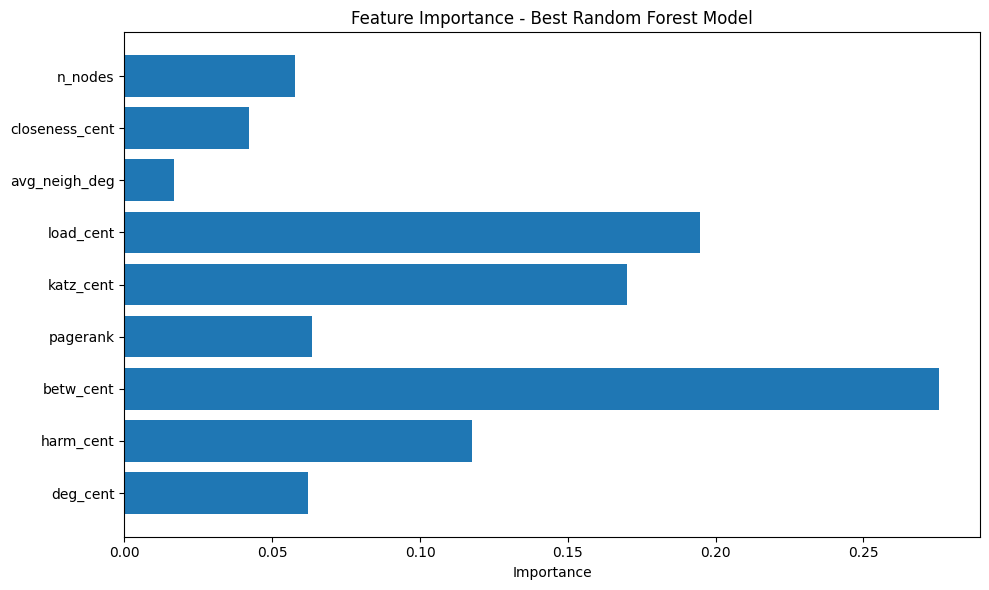

In [18]:
# === Feature Importance Analysis for Best Random Forest ===
import matplotlib.pyplot as plt

# Run separate search for Random Forest to isolate best model
rf_pipe = Pipeline([('model', model_classes['Random Forest'])])
rf_grid = GridSearchCV(rf_pipe, param_grids['Random Forest'], cv=gkf, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train, groups=groups_train)

best_rf_model = rf_grid.best_estimator_.named_steps['model']  # extract RandomForestClassifier from pipeline

# Get importances
importances = best_rf_model.feature_importances_

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features + ['n_nodes'], importances)
plt.title('Feature Importance - Best Random Forest Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [19]:
# === Predicting for the test set using ensemble of best models ===
submission_rows = []
top_k = 3

for idx, row in test_df.iterrows():
    edges = ast.literal_eval(row['edgelist'])
    T = nx.from_edgelist(edges)
    centralities = compute_centralities(edges)

    test_nodes = []
    test_feats = []
    for node, feats in centralities.items():
        test_nodes.append(node)
        test_feats.append(feats)

    test_feats_df = pd.DataFrame(test_feats, columns=features)
    test_feats_df['n_nodes'] = row['n']

    probs = np.zeros(len(test_feats_df))

    # Use the trained best models from the grid search
    for model in best_models.values():
        probs += model.predict_proba(test_feats_df)[:, 1]
    probs /= len(best_models)

    # Select top-k nodes with the highest probabilities
    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_roots = [test_nodes[i] for i in top_indices]

    predicted_root = test_nodes[np.argmax(probs)]
    submission_rows.append({'id': row['id'], 'root': predicted_root})

submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv('submission.csv', index=False)
print("✅ Submission file created: submission.csv")


/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sarasaad/Do

✅ Submission file created: submission.csv


/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sarasaad/Documents/BDMA /UPC/ML/Project/tree-root-prediction/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sarasaad/Do